# 1) Importing Libraries, Data Loading

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

df_train = pd.read_csv(r'/Users/niccolocomar/Documents/Econometria/Data Science/Inventory Management/Store Item Demand Forecasting Challenge/demand-forecasting-kernels-only/train.csv')
df_test = pd.read_csv(r'/Users/niccolocomar/Documents/Econometria/Data Science/Inventory Management/Store Item Demand Forecasting Challenge/demand-forecasting-kernels-only/test.csv')

# 2) Exploratory Data Analysis

In [2]:
def explore_dataset(dataset, title):
    # Title of the dataset
    print(f"\033[1m{title}\033[0m\n")  # Using ANSI escape codes for bold text
    # Displaying the first few rows of the dataset
    print("Head of the dataset:")
    print(dataset.head())
    # Displaying data types
    print("Data types:")
    print(dataset.dtypes, end='\n\n')
    # Displaying dataset information
    print("Dataset information:")
    print(dataset.info(), end='\n\n')
    # Displaying summary statistics
    print("Summary statistics:")
    print(dataset.describe().T, end='\n\n')
    # Displaying the shape of the dataset
    print("Shape of the dataset:")
    print(dataset.shape, end='\n\n')
    # Displaying the number of missing values
    print("Number of missing values:")
    print(dataset.isnull().sum(), end='\n\n')
    # Displaying the number of duplicated rows
    print("Number of duplicated rows:")
    print(dataset.duplicated().sum(), end='\n\n')

In [3]:
explore_dataset(df_train, 'Training')

Training

Head of the dataset:
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
Data types:
date     object
store     int64
item      int64
sales     int64
dtype: object

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

Summary statistics:
          count       mean        std  min   25%   50%   75%    max
store  913000.0   5.500000   2.872283  1.0   3.0   5.5   8.0   10.0
item   913000.0  25.500000  14.430878  1.0  13.0  25.5  38.0   50.0
sales  913000.0  52.250287  28.801144  0

In [4]:
explore_dataset(df_test, 'Testing')

Testing

Head of the dataset:
   id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1
Data types:
id        int64
date     object
store     int64
item      int64
dtype: object

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
None

Summary statistics:
         count     mean           std  min       25%      50%       75%  \
id     45000.0  22499.5  12990.525394  0.0  11249.75  22499.5  33749.25   
store  45000.0      5.5      2.872313  1.0      3.00      5.5      8.00   
item   45000.0     25.5     14.431030  1.0     

Quick insight:
- df_train: it has the target  variable 'sales', that we would like to predict in df_test
- df_test: it doesn't have a 'sales' column. It instead has an 'id' column.

Idea: merging df_train and df_test into a single dataset, feature-engineer it in order to apply extra time-based features, cyclic features, expanding window statistics features, and rolling statistics features.
As there will be no 'sales' column in df_test, the merged dataset will have Nan values for 'sales' in the final part (the one originally from df_test).
Then, we re-split the new dataframe respecting the same split point for df_train and df_test, so we can use the full df_train to train and evaluate our model, to later apply to the final testing dataset in order to get the final sales predictions.

Two things to consider though:
1) It's worth considering that the rolling statistics features (mean, standard deviation, min, max) derive from ‘sales’.
The main issue is that, as we don’t have ‘sales’ in df_test, we will need to estimate such rolling statistics for the df_test portion of the dataset from values we have available in df_train (from which we actually can calculate such rolling statistics, as we do have ‘sales’ values there).
Once trained and validated the model to generate rolling statistics predictions, we use such model in df_test so we can generate such statistics.
2) After having the missing values for the rolling statistics, we can apply them to the main dataframe and get back into creating a NN model for predicting the sales.


# 3) Data preparation, feature engineering

In [2]:
#Converting 'date' from object to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

#Identifying timeframe for df_train
print('Min date from train set: %s' % df_train.date.min().date())
print('Max date from train set: %s' % df_train.date.max().date())

#Identifying timeframe for df_test
print('Min date from test set: %s' % df_test.date.min().date())
print('Max date from test set: %s' % df_test.date.max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31
Min date from test set: 2018-01-01
Max date from test set: 2018-03-31


In [3]:
#Removing 'id' from df_test, so we can merge df_test with df_train into a big df_full dataset
df_test_no_id = df_test.drop('id', axis=1)
df_test_no_id

,date,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1
...,...,...,...
44995,2018-03-27,10,50
44996,2018-03-28,10,50
44997,2018-03-29,10,50
44998,2018-03-30,10,50


In [4]:
#Merging df_train and df_test_no_id into a new dataset called ‘df_full’
df_full = pd.concat([df_train, df_test_no_id], ignore_index=True)
df_full

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
...,...,...,...,...
957995,2018-03-27,10,50,NaN
957996,2018-03-28,10,50,NaN
957997,2018-03-29,10,50,NaN
957998,2018-03-30,10,50,NaN


Feature engineering functions:

1) **adding_lag_features** -> adding extra time-based features to the dataset,
2) **add_cyclic_time_features** -> adding extra cyclic time features, to capture the cyclical nature of time-related data, 
3) **add_expanding_features** -> adding expanding window statistics, which consist of features that include all previous data,
4) **add_rolling_statistics** -> adding extra features using statistics calculated over a rolling window of a specified size that moves through the time series data.

In extra detail:

a) **Expanding window statistics** involve calculating a summary statistic over a growing window of past observations. Unlike rolling statistics, where the window size remains fixed, an expanding window includes all observations from the beginning of the time series up to the current point.

b) **Rolling statistics**, also known as rolling metrics or rolling features, are calculated over a rolling window of a specified size as it moves through the time series data. The rolling window is essentially a subset of data points that "rolls" through the entire dataset, and at each step, the specified statistics are calculated for that subset.

Rolling means lend themselves to feature engineering, and can bring:
- Smoothing: Rolling mean helps smooth out short-term fluctuations, making it easier to identify long-term trends in the data.
- Volatility Analysis: Rolling standard deviation provides insights into the volatility or variability of the time series data.
- Identifying Patterns: Minimum and maximum values help identify patterns, extremes, or outliers within the rolling window.

Issue: adding rolling statistics will result in lots of Nan values, because these rolling statistic features are based on the 'sales' column (for which we only have values originally in df_train). We may need to create predictions for them, attach them to df_full later on in order to be able to make 'sales' final predictions on df_test.


In [5]:
# Feature engineering 1) - Function to add time features

def adding_time_features(df):
    #df['Date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
    df["day"] = df['date'].dt.day
    df["week"] = df['date'].dt.isocalendar().week
    df["month"] = df['date'].dt.month
    df["year"] = df['date'].dt.year
    df["day_of_week"] = df['date'].dt.dayofweek
    df["day_of_year"] = df['date'].dt.dayofyear 
    df["week_of_year"] = df['date'].dt.isocalendar().week
    df["is_weekend"] = df['date'].dt.weekday // 4
    df["is_month_start"] = df['date'].dt.is_month_start.astype(int)
    df["is_month_end"] = df['date'].dt.is_month_end.astype(int) 
    
    return df


# Feature engineering 2) - Function to add cyclical time features:

def add_cyclic_time_features(df):
    df["sin_day_of_week"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["cos_day_of_week"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)
    df["sin_day_of_year"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
    df["cos_day_of_year"] = np.cos(2 * np.pi * df["day_of_year"] / 365)
    df["sin_week_of_year"] = np.sin(2 * np.pi * df["week_of_year"] / 52)
    df["cos_week_of_year"] = np.cos(2 * np.pi * df["week_of_year"] / 52)
    
    return df



# Feature engineering 3) - Function to add expanding features:

def add_expanding_features(df, target_column):
    """
    Add expanding window statistics as features to the DataFrame.

    Parameters:
    - df: DataFrame
    - target_column: str, the column for which expanding features are calculated

    Returns:
    - DataFrame with additional expanding window features
    """
# Expanding mean
    df[f'{target_column}_expanding_mean'] = df[target_column].expanding().mean()
    
    # Expanding standard deviation
    df[f'{target_column}_expanding_std'] = df[target_column].expanding().std()
    
    # Expanding minimum
    df[f'{target_column}_expanding_min'] = df[target_column].expanding().min()
    
    # Expanding maximum
    df[f'{target_column}_expanding_max'] = df[target_column].expanding().max()

    # Drop rows with NaN values created by expanding window
    df = df.dropna()

    return df


# Feature engineering 4) - Function to add rolling statistics

def add_rolling_statistics(df, window_size):
    df['rolling_mean'] = df['sales'].rolling(window=window_size).mean()
    df['rolling_std'] = df['sales'].rolling(window=window_size).std()
    df['rolling_min'] = df['sales'].rolling(window=window_size).min()
    df['rolling_max'] = df['sales'].rolling(window=window_size).max()
    
    return df

In [6]:
#Generating all extra features from the functions above and adding them to df_train

adding_time_features(df_full)

add_cyclic_time_features(df_full)

add_expanding_features(df_full, target_column='sales')

add_rolling_statistics(df_full, window_size=7)

df_full.shape

(958000, 30)

In [7]:
df_full.columns

Index(['date', 'store', 'item', 'sales', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max',
       'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max'],
      dtype='object')

In [8]:
df_full.isnull().sum()

date                        0
store                       0
item                        0
sales                   45000
day                         0
week                        0
month                       0
year                        0
day_of_week                 0
day_of_year                 0
week_of_year                0
is_weekend                  0
is_month_start              0
is_month_end                0
sin_day_of_week             0
cos_day_of_week             0
sin_month                   0
cos_month                   0
sin_day_of_year             0
cos_day_of_year             0
sin_week_of_year            0
cos_week_of_year            0
sales_expanding_mean        0
sales_expanding_std         1
sales_expanding_min         0
sales_expanding_max         0
rolling_mean            45006
rolling_std             45006
rolling_min             45006
rolling_max             45006
dtype: int64

In [9]:
# Remove rows with NaN in 'sales_expanding_std' column
df_full = df_full.dropna(subset=['sales_expanding_std'])

In [10]:
df_full.isnull().sum()

date                        0
store                       0
item                        0
sales                   45000
day                         0
week                        0
month                       0
year                        0
day_of_week                 0
day_of_year                 0
week_of_year                0
is_weekend                  0
is_month_start              0
is_month_end                0
sin_day_of_week             0
cos_day_of_week             0
sin_month                   0
cos_month                   0
sin_day_of_year             0
cos_day_of_year             0
sin_week_of_year            0
cos_week_of_year            0
sales_expanding_mean        0
sales_expanding_std         0
sales_expanding_min         0
sales_expanding_max         0
rolling_mean            45005
rolling_std             45005
rolling_min             45005
rolling_max             45005
dtype: int64

# 4) Predicting future rolling_mean, rolling_std, rolling_min, rolling_max values to attach to df_full (for later predicting sales)

In [11]:
# Extracting the first subset (all rows but the final 45005)
df_a = df_full.iloc[:-45005]

# Extracting the second subset (the final 45005 rows)
df_b = df_full.iloc[-45005:]

df_a.isnull().sum()

date                    0
store                   0
item                    0
sales                   0
day                     0
week                    0
month                   0
year                    0
day_of_week             0
day_of_year             0
week_of_year            0
is_weekend              0
is_month_start          0
is_month_end            0
sin_day_of_week         0
cos_day_of_week         0
sin_month               0
cos_month               0
sin_day_of_year         0
cos_day_of_year         0
sin_week_of_year        0
cos_week_of_year        0
sales_expanding_mean    0
sales_expanding_std     0
sales_expanding_min     0
sales_expanding_max     0
rolling_mean            5
rolling_std             5
rolling_min             5
rolling_max             5
dtype: int64

In [12]:
df_a1 = df_a.dropna()
df_a1.isnull().sum()

date                    0
store                   0
item                    0
sales                   0
day                     0
week                    0
month                   0
year                    0
day_of_week             0
day_of_year             0
week_of_year            0
is_weekend              0
is_month_start          0
is_month_end            0
sin_day_of_week         0
cos_day_of_week         0
sin_month               0
cos_month               0
sin_day_of_year         0
cos_day_of_year         0
sin_week_of_year        0
cos_week_of_year        0
sales_expanding_mean    0
sales_expanding_std     0
sales_expanding_min     0
sales_expanding_max     0
rolling_mean            0
rolling_std             0
rolling_min             0
rolling_max             0
dtype: int64

In [13]:
df_b.isnull().sum()

date                        0
store                       0
item                        0
sales                   45000
day                         0
week                        0
month                       0
year                        0
day_of_week                 0
day_of_year                 0
week_of_year                0
is_weekend                  0
is_month_start              0
is_month_end                0
sin_day_of_week             0
cos_day_of_week             0
sin_month                   0
cos_month                   0
sin_day_of_year             0
cos_day_of_year             0
sin_week_of_year            0
cos_week_of_year            0
sales_expanding_mean        0
sales_expanding_std         0
sales_expanding_min         0
sales_expanding_max         0
rolling_mean            45000
rolling_std             45000
rolling_min             45000
rolling_max             45000
dtype: int64

In [14]:
df_a1.shape, df_b.shape

((912989, 30), (45005, 30))

In [15]:
df_a1.columns

Index(['date', 'store', 'item', 'sales', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max',
       'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max'],
      dtype='object')

In [16]:
rolling_features = ['store', 'item', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max'] #leaving 'date' and 'sales' out

**Feature selection wiith correlation** in df_a1 features related to rolling statistics

In [17]:
features = df_a1[rolling_features]
targets = df_a1[['rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']]

# Calculate the correlation matrix
correlation_matrix = pd.concat([features, targets], axis=1).corr()

# Extract correlations with the target variables
target_correlations = correlation_matrix[['rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']]

# Display the correlation coefficients
target_correlations

,rolling_mean,rolling_std,rolling_min,rolling_max
store,-0.008840,-0.007882,-0.008402,-0.008572
item,-0.059765,-0.048730,-0.059019,-0.058944
day,0.002626,-0.029880,0.009814,-0.004507
week,0.105568,0.090391,0.102674,0.104976
month,0.106792,0.094385,0.103184,0.106859
year,0.192717,0.153031,0.189639,0.188783
day_of_week,-0.000125,0.001859,0.000037,0.000965
day_of_year,0.105613,0.090722,0.102637,0.105098
week_of_year,0.105568,0.090391,0.102674,0.104976
is_weekend,-0.000038,0.002283,0.000067,0.001288


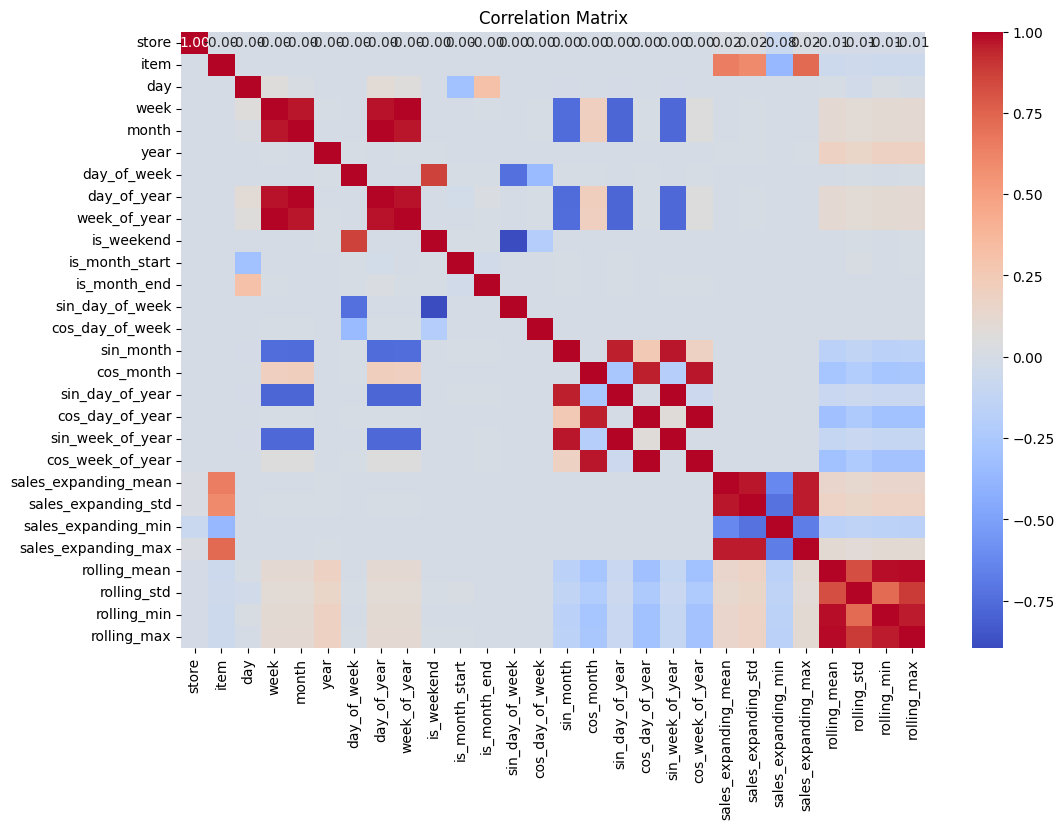

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [19]:
from scipy.stats import pearsonr

rolling_statistics_columns = ['rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']
features = df_a1[rolling_features]

non_significant_features_per_statistic = {statistic: [] for statistic in rolling_statistics_columns}

# Iterate over the features and rolling statistics columns
for column in features.columns:
    for target_column in rolling_statistics_columns:
        correlation, p_value = pearsonr(features[column], df_a1[target_column])
        if p_value < 0.05:
            print(f"'{column}' correlation against '{target_column}' is statistically significant (p-value = {p_value:.4f} < 0.05)")
        else:
            print(f"'{column}' correlation against '{target_column}' is not statistically significant (p-value = {p_value:.4f} > 0.05)")
            non_significant_features_per_statistic[target_column].append(column)

# Print non-significant features for each rolling statistic column
for statistic, non_significant_features in non_significant_features_per_statistic.items():
    print(f"\nNon-significant features for '{statistic}': {non_significant_features}")

# Find common features among non-significant lists
common_non_significant_features = set.intersection(*map(set, non_significant_features_per_statistic.values()))
print(f"\nCommon non-significant features among all rolling statistics columns: {common_non_significant_features}")

'store' correlation against 'rolling_mean' is statistically significant (p-value = 0.0000 < 0.05)
'store' correlation against 'rolling_std' is statistically significant (p-value = 0.0000 < 0.05)
'store' correlation against 'rolling_min' is statistically significant (p-value = 0.0000 < 0.05)
'store' correlation against 'rolling_max' is statistically significant (p-value = 0.0000 < 0.05)
'item' correlation against 'rolling_mean' is statistically significant (p-value = 0.0000 < 0.05)
'item' correlation against 'rolling_std' is statistically significant (p-value = 0.0000 < 0.05)
'item' correlation against 'rolling_min' is statistically significant (p-value = 0.0000 < 0.05)
'item' correlation against 'rolling_max' is statistically significant (p-value = 0.0000 < 0.05)
'day' correlation against 'rolling_mean' is statistically significant (p-value = 0.0121 < 0.05)
'day' correlation against 'rolling_std' is statistically significant (p-value = 0.0000 < 0.05)
'day' correlation against 'rolling_

In [20]:
#We will remove from the feature list: ['day_of_week', 'is_weekend', 'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week']
# We would like to keep the number of features low, so to reduce multicollinearity and model complexity

features_kept = ['store', 'item', 'day', 'week', 'month', 'year',
                   'day_of_year', 'week_of_year', 
                  'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
                  'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max']

In [21]:
#Creating a features array(X_a) and target array(the 4 variables we want to predict) from df_a
X_a = df_a1[features_kept]
y_a = df_a1[['rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']]
X_a.shape, y_a.shape

((912989, 18), (912989, 4))

In [22]:
from sklearn.model_selection import train_test_split

X_a_train, X_a_valid, y_a_train, y_a_valid = train_test_split(X_a, y_a, test_size=0.2, random_state=None)
X_a_train.shape, X_a_valid.shape, y_a_train.shape, y_a_valid.shape

((730391, 18), (182598, 18), (730391, 4), (182598, 4))

In [23]:
#Training a Random Forest Regressor model for predicting the 4 rolling statistics values (our target are 4 variables)

from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_a_train, y_a_train)

RandomForestRegressor()

In [24]:
#Predictions on training set (X_a_train)
predictions_roll_train = rfr.predict(X_a_train)
predictions_roll_train

array([[65.06857143,  5.82109016, 54.91      , 70.22      ],
       [23.32      ,  6.75730453, 11.14      , 31.25      ],
       [51.59714286,  6.92698304, 43.91      , 61.3       ],
       ...,
       [74.58857143,  6.27151638, 66.21      , 83.58      ],
       [37.92571429, 10.52613618, 23.69      , 53.55      ],
       [44.98285714,  5.75064674, 37.71      , 52.34      ]])

In [25]:
#Predictions on validation set (X_a_valid)
predictions_roll_valid = rfr.predict(X_a_valid)
predictions_roll_valid

array([[ 51.87571429,  10.04331781,  36.37      ,  65.        ],
       [109.08714286,  15.11018741,  90.54      , 135.06      ],
       [ 66.32428571,  13.95654095,  45.97      ,  84.8       ],
       ...,
       [ 39.12      ,   7.27486409,  29.08      ,  49.13      ],
       [ 31.07428571,   8.03099977,  19.44      ,  45.64      ],
       [ 16.71714286,   3.61318453,  11.15      ,  21.63      ]])

In [26]:
feature_importances = pd.Series(rfr.feature_importances_, index=X_a.columns)
print(feature_importances)

store                   0.101613
item                    0.549425
day                     0.004203
week                    0.001057
month                   0.000265
year                    0.038924
day_of_year             0.004471
week_of_year            0.001059
sin_month               0.000244
cos_month               0.000524
sin_day_of_year         0.031949
cos_day_of_year         0.091512
sin_week_of_year        0.001198
cos_week_of_year        0.002470
sales_expanding_mean    0.102996
sales_expanding_std     0.063144
sales_expanding_min     0.000047
sales_expanding_max     0.004898
dtype: float64


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Metrics for the training set
mse_train = mean_squared_error(y_a_train, predictions_roll_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_a_train, predictions_roll_train)
r2_train = r2_score(y_a_train, predictions_roll_train)

# Metrics for the validation set
mse_valid = mean_squared_error(y_a_valid, predictions_roll_valid)
rmse_valid = np.sqrt(mse_valid)
mae_valid = mean_absolute_error(y_a_valid, predictions_roll_valid)
r2_valid = r2_score(y_a_valid, predictions_roll_valid)

print(f"Training set metrics:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R2 on training set: {r2_train}")

print("\nValidation set metrics:")
print(f"MSE: {mse_valid}")
print(f"RMSE: {rmse_valid}")
print(f"MAE: {mae_valid}")
print(f"R2 on validation set: {r2_valid}")

Training set metrics:
MSE: 0.6558881501903847
RMSE: 0.8098692179545934
MAE: 0.4608262770779227
R2 on training set: 0.9966249174349808

Validation set metrics:
MSE: 4.640110642808386
RMSE: 2.154091605017852
MAE: 1.2379122254542205
R2 on validation set: 0.9759140169092997


The RFR does a very good job. Possible overfitting, but it actually performed pretty good in accuracy using the validation data (R2=0.975).
Also MSE, RMSE and MAE are very low.
Needless to say, the rolling statistics are designed around ‘sales’ data, which we cannot use here, so it’s not the optimal scenario. Let’s still try to make the most out of this and use the RFR model to predict the missing values to the  rolling statistic features.

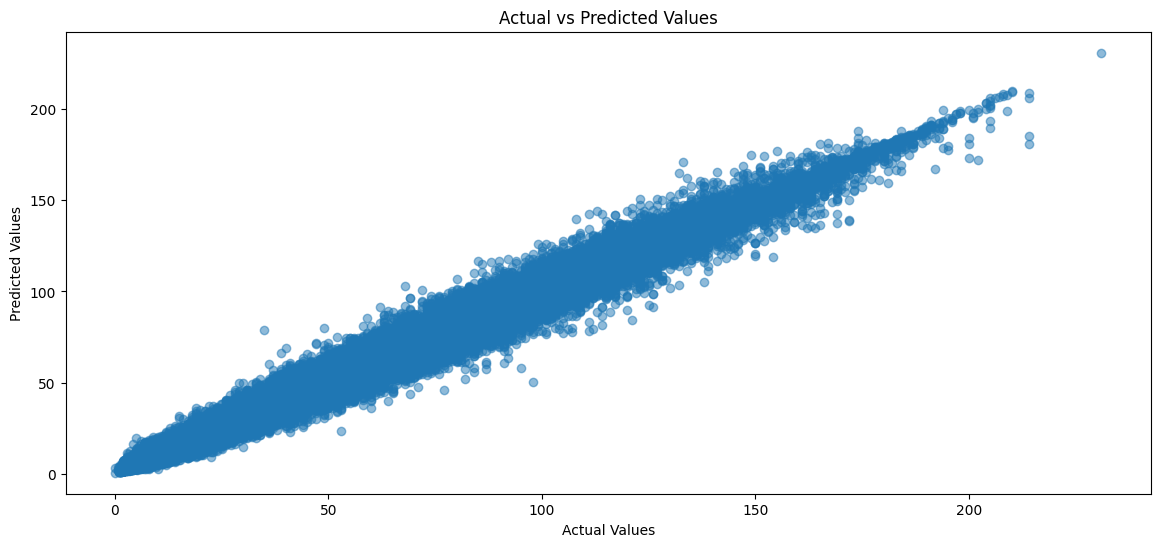

In [41]:
# Plotting y_a_valid against predictions_roll_valid
plt.figure(figsize=(14, 6))
plt.scatter(y_a_valid, predictions_roll_valid, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

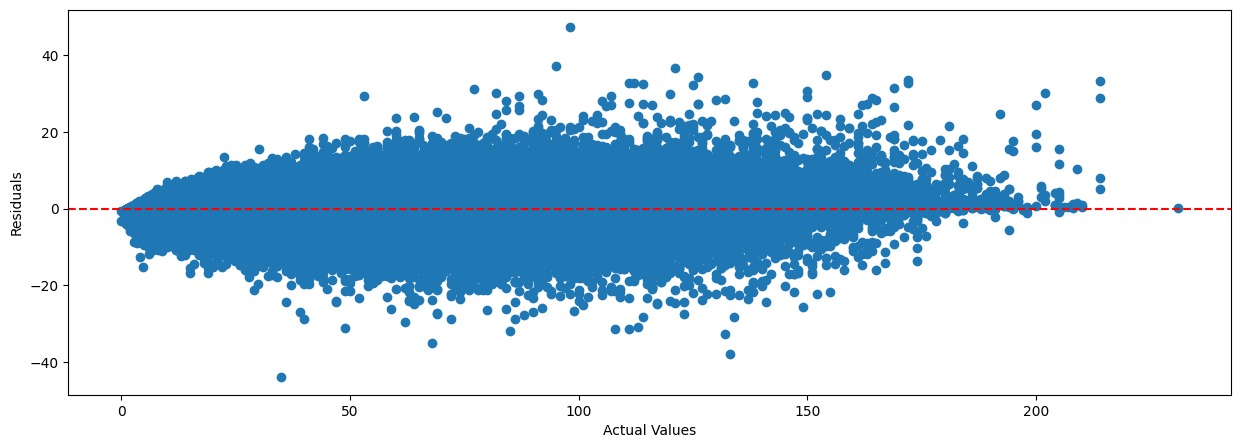

In [28]:
residuals = y_a_valid - predictions_roll_valid
plt.figure(figsize=(15,5))
plt.scatter(y_a_valid, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

**Making rolling statistics predictions on df_b**

In [33]:
#Selecting features for df_b
X_b = df_b[features_kept]
X_b

,store,item,day,week,month,year,day_of_year,week_of_year,sin_month,cos_month,sin_day_of_year,cos_day_of_year,sin_week_of_year,cos_week_of_year,sales_expanding_mean,sales_expanding_std,sales_expanding_min,sales_expanding_max
912995,10,50,27,52,12,2017,361,52,-2.449294e-16,1.000000e+00,-6.880243e-02,0.997630,0.0,1.0,52.250212,28.801178,0.0,231.0
912996,10,50,28,52,12,2017,362,52,-2.449294e-16,1.000000e+00,-5.161967e-02,0.998667,0.0,1.0,52.250220,28.801163,0.0,231.0
912997,10,50,29,52,12,2017,363,52,-2.449294e-16,1.000000e+00,-3.442161e-02,0.999407,0.0,1.0,52.250244,28.801157,0.0,231.0
912998,10,50,30,52,12,2017,364,52,-2.449294e-16,1.000000e+00,-1.721336e-02,0.999852,0.0,1.0,52.250254,28.801143,0.0,231.0
912999,10,50,31,52,12,2017,365,52,-2.449294e-16,1.000000e+00,6.432491e-16,1.000000,0.0,1.0,52.250287,28.801144,0.0,231.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957995,10,50,27,13,3,2018,86,13,1.000000e+00,6.123234e-17,9.959190e-01,0.090252,1.0,-0.0,52.250287,28.801144,0.0,231.0
957996,10,50,28,13,3,2018,87,13,1.000000e+00,6.123234e-17,9.973250e-01,0.073095,1.0,-0.0,52.250287,28.801144,0.0,231.0
957997,10,50,29,13,3,2018,88,13,1.000000e+00,6.123234e-17,9.984354e-01,0.055917,1.0,-0.0,52.250287,28.801144,0.0,231.0
957998,10,50,30,13,3,2018,89,13,1.000000e+00,6.123234e-17,9.992500e-01,0.038722,1.0,-0.0,52.250287,28.801144,0.0,231.0


In [30]:
print(X_b.isnull().sum())

store                   0
item                    0
day                     0
week                    0
month                   0
year                    0
day_of_year             0
week_of_year            0
sin_month               0
cos_month               0
sin_day_of_year         0
cos_day_of_year         0
sin_week_of_year        0
cos_week_of_year        0
sales_expanding_mean    0
sales_expanding_std     0
sales_expanding_min     0
sales_expanding_max     0
dtype: int64


In [31]:
# Check for infinite values in X_b
print(np.isinf(X_b).sum())

store                   0
item                    0
day                     0
week                    0
month                   0
year                    0
day_of_year             0
week_of_year            0
sin_month               0
cos_month               0
sin_day_of_year         0
cos_day_of_year         0
sin_week_of_year        0
cos_week_of_year        0
sales_expanding_mean    0
sales_expanding_std     0
sales_expanding_min     0
sales_expanding_max     0
dtype: Int64


In [32]:
# Check for zero values in X_b
print((X_b == 0).sum())

store                       0
item                        0
day                         0
week                        0
month                       0
year                        0
day_of_year                 0
week_of_year                0
sin_month                   0
cos_month                   0
sin_day_of_year             0
cos_day_of_year             0
sin_week_of_year            0
cos_week_of_year            0
sales_expanding_mean        0
sales_expanding_std         0
sales_expanding_min     45005
sales_expanding_max         0
dtype: Int64


In [34]:
#Predicting rolling statistics using the trained RFR model
predictions_roll_b = rfr.predict(X_b)
predictions_roll_b

array([[61.61285714, 12.25987439, 45.2       , 76.08      ],
       [61.63142857, 12.24967162, 45.2       , 76.08      ],
       [61.60428571, 12.29171676, 45.07      , 76.08      ],
       ...,
       [69.21285714,  9.79039395, 56.45      , 83.71      ],
       [69.16142857,  9.53837702, 56.77      , 83.24      ],
       [69.04428571,  9.48982143, 56.58      , 83.24      ]])

In [35]:
len(predictions_roll_b)

45005

In [36]:
 print(df_b.shape)

(45005, 30)


In [37]:
#Assigning the rolling statistic prediction values to the respective columns in df_b
df_b[['rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']] = predictions_roll_b
df_b

/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/117306513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b[['rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']] = predictions_roll_b


,date,store,item,sales,day,week,month,year,day_of_week,day_of_year,...,sin_week_of_year,cos_week_of_year,sales_expanding_mean,sales_expanding_std,sales_expanding_min,sales_expanding_max,rolling_mean,rolling_std,rolling_min,rolling_max
912995,2017-12-27,10,50,63.0,27,52,12,2017,2,361,...,0.0,1.0,52.250212,28.801178,0.0,231.0,61.612857,12.259874,45.20,76.08
912996,2017-12-28,10,50,59.0,28,52,12,2017,3,362,...,0.0,1.0,52.250220,28.801163,0.0,231.0,61.631429,12.249672,45.20,76.08
912997,2017-12-29,10,50,74.0,29,52,12,2017,4,363,...,0.0,1.0,52.250244,28.801157,0.0,231.0,61.604286,12.291717,45.07,76.08
912998,2017-12-30,10,50,62.0,30,52,12,2017,5,364,...,0.0,1.0,52.250254,28.801143,0.0,231.0,61.604286,12.291717,45.07,76.08
912999,2017-12-31,10,50,82.0,31,52,12,2017,6,365,...,0.0,1.0,52.250287,28.801144,0.0,231.0,61.604286,12.291717,45.07,76.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957995,2018-03-27,10,50,NaN,27,13,3,2018,1,86,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,68.805714,10.293900,55.73,84.08
957996,2018-03-28,10,50,NaN,28,13,3,2018,2,87,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,68.758571,10.198165,55.74,83.88
957997,2018-03-29,10,50,NaN,29,13,3,2018,3,88,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,69.212857,9.790394,56.45,83.71
957998,2018-03-30,10,50,NaN,30,13,3,2018,4,89,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,69.161429,9.538377,56.77,83.24


In [38]:
df_b.isnull().sum()

date                        0
store                       0
item                        0
sales                   45000
day                         0
week                        0
month                       0
year                        0
day_of_week                 0
day_of_year                 0
week_of_year                0
is_weekend                  0
is_month_start              0
is_month_end                0
sin_day_of_week             0
cos_day_of_week             0
sin_month                   0
cos_month                   0
sin_day_of_year             0
cos_day_of_year             0
sin_week_of_year            0
cos_week_of_year            0
sales_expanding_mean        0
sales_expanding_std         0
sales_expanding_min         0
sales_expanding_max         0
rolling_mean                0
rolling_std                 0
rolling_min                 0
rolling_max                 0
dtype: int64

We successfully predicted the missing values of the four rolling statistics columns, as previously present in the subset df_b.

Now the only missing values are the actual main target values to predict, being the sales between 01/01/2018 to 31/03/2018.

As hinted before, we will now merge df_a and df_b back together into df_full. We will then re-split into df_train (all data up to 31/12/2017) and df_test (data from 01/01/2018 onwards), so df_train will be used for training and evaluating the model.

The final model will hence be applied to the features in df_test, so we can predict the final future sales.

In [39]:
#Merging df_a1 (df_a without Nans) and df_b back into a new ‘df_full1’ main dataset
df_full1 = pd.concat([df_a1, df_b], ignore_index=True)
df_full1

,date,store,item,sales,day,week,month,year,day_of_week,day_of_year,...,sin_week_of_year,cos_week_of_year,sales_expanding_mean,sales_expanding_std,sales_expanding_min,sales_expanding_max,rolling_mean,rolling_std,rolling_min,rolling_max
0,2013-01-07,1,1,10.0,7,2,1,2013,0,7,...,0.239316,0.970942,11.857143,1.573592,10.0,14.0,11.857143,1.573592,10.00,14.00
1,2013-01-08,1,1,9.0,8,2,1,2013,1,8,...,0.239316,0.970942,11.500000,1.772811,9.0,14.0,11.285714,1.799471,9.00,14.00
2,2013-01-09,1,1,12.0,9,2,1,2013,2,9,...,0.239316,0.970942,11.555556,1.666667,9.0,14.0,11.428571,1.812654,9.00,14.00
3,2013-01-10,1,1,9.0,10,2,1,2013,3,10,...,0.239316,0.970942,11.300000,1.766981,9.0,14.0,10.714286,1.603567,9.00,13.00
4,2013-01-11,1,1,9.0,11,2,1,2013,4,11,...,0.239316,0.970942,11.090909,1.814086,9.0,14.0,10.142857,1.345185,9.00,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957989,2018-03-27,10,50,NaN,27,13,3,2018,1,86,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,68.805714,10.293900,55.73,84.08
957990,2018-03-28,10,50,NaN,28,13,3,2018,2,87,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,68.758571,10.198165,55.74,83.88
957991,2018-03-29,10,50,NaN,29,13,3,2018,3,88,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,69.212857,9.790394,56.45,83.71
957992,2018-03-30,10,50,NaN,30,13,3,2018,4,89,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,69.161429,9.538377,56.77,83.24


In [40]:
df_full1.isnull().sum()

date                        0
store                       0
item                        0
sales                   45000
day                         0
week                        0
month                       0
year                        0
day_of_week                 0
day_of_year                 0
week_of_year                0
is_weekend                  0
is_month_start              0
is_month_end                0
sin_day_of_week             0
cos_day_of_week             0
sin_month                   0
cos_month                   0
sin_day_of_year             0
cos_day_of_year             0
sin_week_of_year            0
cos_week_of_year            0
sales_expanding_mean        0
sales_expanding_std         0
sales_expanding_min         0
sales_expanding_max         0
rolling_mean                0
rolling_std                 0
rolling_min                 0
rolling_max                 0
dtype: int64

In [103]:
df_full1.columns

Index(['date', 'store', 'item', 'sales', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max',
       'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max'],
      dtype='object')

In [44]:
#Splitting df_full1 again to df_train/df_test sets using December, 31st 2017 as split date

split_date = '2017-12-31'

df_train = df_full1[df_full1['date'] <= split_date].copy()
df_test = df_full1[df_full1['date'] > split_date].copy()
df_train.shape, df_test.shape

((912994, 30), (45000, 30))

The dataset is large, and when instantiating a NN model using the full df_train set unfortunately my kernel dies.

As I have previously already analyzed that sales per item and sales per store follow a similar trend regardless of the item or the store, we can decide to use just a portion of the main dataset related to one specific item and one specific store.

We will pick **item 1** and **store 1**.


In [45]:
#For simplicity, let's investigate only data related to the first item and store 1
df_train1 = df_train.loc[df_train["item"] == 1]
df_train11 = df_train1.loc[df_train1["store"] == 1]

df_test1 = df_test.loc[df_test["item"] == 1]
df_test11 = df_test1.loc[df_test1["store"] == 1]

df_train11.shape, df_test11.shape

((1820, 30), (90, 30))

# 5) Splitting df_train11 into training and testing sets for NN modeling

In [46]:
df_train11.columns

Index(['date', 'store', 'item', 'sales', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max',
       'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max'],
      dtype='object')

Now, the idea is to:
- create a **target** (‘sales’) array, and scale it using a dedicated scaler (sales_scaler),
- create a **features** array (without ‘date’) and scale it using a dedicated scaler (features_scaler),
- passing the scaled features and the scaled target to a function called ‘create_sequences’, so X and y sequences will be generated according to a specific chosen timestamp,
- splitting X and y to create X_train, y_train, X_val, y_val, which we will use to train and validate our model.


In [47]:
#Scaling target data

from sklearn.preprocessing import MinMaxScaler

sales = np.array(df_train11["sales"].values).reshape(-1, 1)
# sales_scaler = StandardScaler()
sales_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales = sales_scaler.fit_transform(sales)

In [48]:
#Scaling feature data

cols = ['store', 'item', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max',
       'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max'] #All features but 'date', also excluding 'sales' as it's the target variable

features = df_train11[cols].values
# features_scaler = StandardScaler(with_mean=False)
features_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = features_scaler.fit_transform(features)

In [49]:
scaled_features.shape, scaled_sales.shape

((1820, 28), (1820, 1))

In [50]:
#Function to create X and y sequences from feature data, target and a sequence length (so they could be used in NN modeling)

def create_sequences(data, target, sequence_length):
    X, y = [], []
    for index in range(len(data) - sequence_length):
        X.append(data[index:index+sequence_length])
        y.append(target[index+sequence_length])
    
    return np.array(X), np.array(y)


timesteps = 30
X, y = create_sequences(scaled_features, scaled_sales, timesteps)


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1432, 30, 28), (1432, 1), (358, 30, 28), (358, 1))

# 6) NN modeling - LSTM

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#Building a simple LSTM model (model 1)
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))   #sequence_length =30 -> equal to X_train.shape[1]
model.add(Dense(units=1)) # Output layer with 1 unit for predicting 'sales'
model.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h1', monitor='val_loss', save_best_only=True)

#Training the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 0.0513

INFO:tensorflow:Assets written to: best_model.h1/assets


INFO:tensorflow:Assets written to: best_model.h1/assets


36/36 [==============================] - 4s 83ms/step - loss: 0.0513 - val_loss: 0.0575
Epoch 2/50
34/36 [===========================>..] - ETA: 0s - loss: 0.0418

INFO:tensorflow:Assets written to: best_model.h1/assets


INFO:tensorflow:Assets written to: best_model.h1/assets


36/36 [==============================] - 2s 65ms/step - loss: 0.0423 - val_loss: 0.0462
Epoch 3/50
36/36 [==============================] - 1s 20ms/step - loss: 0.0415 - val_loss: 0.0463
Epoch 4/50
36/36 [==============================] - 1s 20ms/step - loss: 0.0401 - val_loss: 0.0469
Epoch 5/50
34/36 [===========================>..] - ETA: 0s - loss: 0.0396

INFO:tensorflow:Assets written to: best_model.h1/assets


INFO:tensorflow:Assets written to: best_model.h1/assets


36/36 [==============================] - 3s 72ms/step - loss: 0.0399 - val_loss: 0.0452
Epoch 6/50
36/36 [==============================] - ETA: 0s - loss: 0.0378

INFO:tensorflow:Assets written to: best_model.h1/assets


INFO:tensorflow:Assets written to: best_model.h1/assets


36/36 [==============================] - 2s 64ms/step - loss: 0.0378 - val_loss: 0.0426
Epoch 7/50
36/36 [==============================] - 1s 20ms/step - loss: 0.0370 - val_loss: 0.0456
Epoch 8/50
36/36 [==============================] - 1s 20ms/step - loss: 0.0366 - val_loss: 0.0443
Epoch 9/50
34/36 [===========================>..] - ETA: 0s - loss: 0.0374

INFO:tensorflow:Assets written to: best_model.h1/assets


INFO:tensorflow:Assets written to: best_model.h1/assets


36/36 [==============================] - 2s 70ms/step - loss: 0.0374 - val_loss: 0.0412
Epoch 10/50
36/36 [==============================] - 1s 20ms/step - loss: 0.0367 - val_loss: 0.0423
Epoch 11/50
36/36 [==============================] - 1s 19ms/step - loss: 0.0359 - val_loss: 0.0415
Epoch 12/50
36/36 [==============================] - 1s 19ms/step - loss: 0.0363 - val_loss: 0.0445
Epoch 13/50
36/36 [==============================] - 1s 19ms/step - loss: 0.0359 - val_loss: 0.0476
Epoch 14/50
36/36 [==============================] - 1s 19ms/step - loss: 0.0366 - val_loss: 0.0434


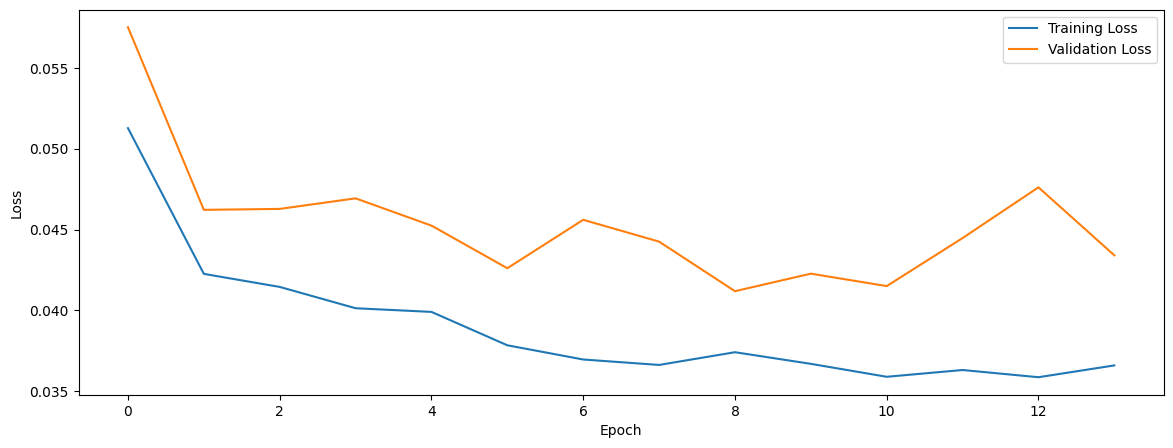

In [54]:
# Plotting the loss (= difference between the predicted output and the true target values. The goal during the training of a machine learning model is to minimize this loss)
plt.figure(figsize=(14,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
#Predict on the validation(=testing) set
predictions = model.predict(X_val)
predictions.shape

12/12 [==============================] - 0s 7ms/step


(358, 1)

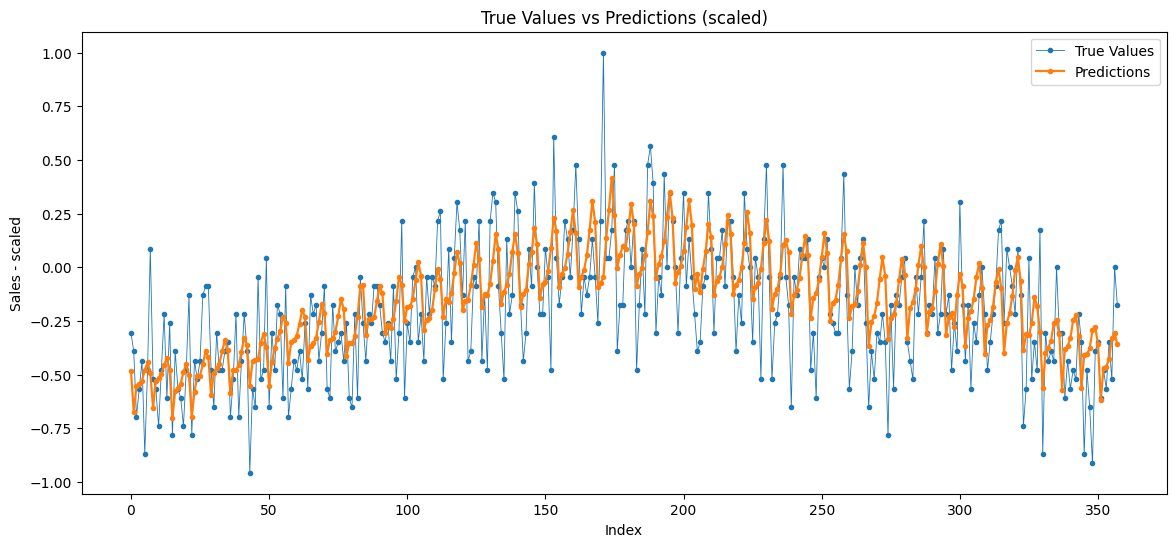

In [56]:
#Plotting the true values from the test set and predicted values (both scaled)
plt.figure(figsize=(14, 6))
plt.plot(y_val, label='True Values', marker='.', linewidth=0.6)
plt.plot(predictions, label='Predictions', marker='.', linewidth=1.6)
plt.title('True Values vs Predictions (scaled)')
plt.xlabel('Index')
plt.ylabel('Sales - scaled')
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Evaluate the model
mse = np.mean((predictions - y_val) ** 2)
rmse = np.sqrt(np.mean(predictions - y_val)**2) 
mae = mean_absolute_error(y_val, predictions)
mape = mean_absolute_percentage_error(y_val, predictions)
smape = symmetric_mean_absolute_percentage_error(y_val, predictions)

print("LSTM model - Mean Squared Error (MSE):", mse)
print("LSTM model - Mean Absolute Error (MAE):", mae)
print("LSTM model - Root Mean Squared Error (RMSE):", rmse)
print("LSTM model - Mean Absolute Percentage Error (MAPE):", mape)
print("LSTM model - Symmetric Mean Absolute Percentage Error (SMAPE):", smape)

LSTM model - Mean Squared Error (MSE): 0.04775872235230333
LSTM model - Mean Absolute Error (MAE): 0.17849015458700743
LSTM model - Root Mean Squared Error (RMSE): 0.04555682608582213
LSTM model - Mean Absolute Percentage Error (MAPE): inf
LSTM model - Symmetric Mean Absolute Percentage Error (SMAPE): 92.76105792485421


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/1955489358.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [58]:
# Inverse transform the scaled predictions (so we can have the predictions from the test set in the original data scale)
unscaled_predictions = sales_scaler.inverse_transform(predictions)

In [59]:
# Inverse transform y_test (so we can have the actual sales values of the test dataset in the original data scale)
unscaled_y_val = sales_scaler.inverse_transform(y_val)

<function matplotlib.pyplot.show(close=None, block=None)>

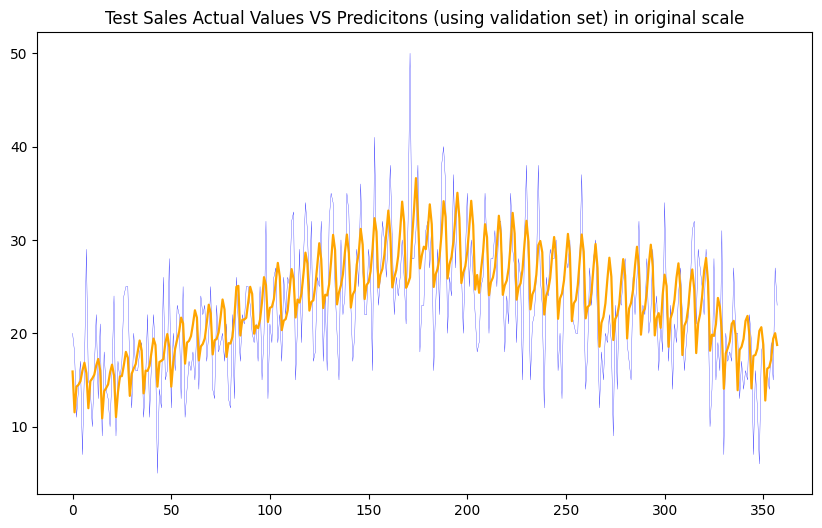

In [60]:
#Plotting unscaled predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(unscaled_y_val, linewidth=0.2, color = 'blue')
plt.plot(unscaled_predictions, linewidth=1.6, color = 'orange')
plt.title('Test Sales Actual Values VS Predicitons (using validation set) in original scale')
plt.show

# 7) Hyperparameter tuning to the LSTM model

In [61]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

def create_lstm_model(input_shape, units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    mae = mean_absolute_error(y, y_pred)
    
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    
    smape = 2 * np.mean(np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'SMAPE': smape
    }

def find_best_model(X_train, y_train, X_test, y_test, param_grid):
    best_mse = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), **params)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        mse = evaluate_model(model, X_test, y_test)['MSE']

        if mse < best_mse:
            best_mse = mse
            best_params = params

    return best_params

In [62]:
param_grid = {
    'units': [50, 75, 100, 125, 150],
    'dropout_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.4],
}

In [63]:
#Find the parameters
best_params = find_best_model(X_train, y_train, X_val, y_val, param_grid)

12/12 [==============================] - 0s 8ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 13ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 10ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 8ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 9ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 8ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 10ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 9ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 7ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 7ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 8ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 9ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 8ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 8ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 11ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 10ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 1s 17ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 1s 12ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 10ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 11ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 11ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 11ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 11ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 10ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 10ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 11ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 12ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 12ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 10ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


12/12 [==============================] - 0s 11ms/step


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


In [64]:
best_params

{'dropout_rate': 0.25, 'units': 150}

In [65]:
# Use the best parameters to create the final model
best_units = best_params['units']
best_dropout_rate = best_params['dropout_rate']

tuned_model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), units=best_units, dropout_rate=best_dropout_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the final model on the entire training set
history_tuned = tuned_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the final model on the validation set
tuned_model_evaluation = evaluate_model(tuned_model, X_val, y_val)

print("Tuned LSTM Model Evaluation:")
print(tuned_model_evaluation)

Epoch 1/100
36/36 [==============================] - 4s 72ms/step - loss: 0.0717 - val_loss: 0.0497
Epoch 2/100
36/36 [==============================] - 1s 21ms/step - loss: 0.0421 - val_loss: 0.0451
Epoch 3/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0420 - val_loss: 0.0455
Epoch 4/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0400 - val_loss: 0.0453
Epoch 5/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0391 - val_loss: 0.0440
Epoch 6/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0392 - val_loss: 0.0432
Epoch 7/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0384 - val_loss: 0.0497
Epoch 8/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0378 - val_loss: 0.0456
Epoch 9/100
36/36 [==============================] - 1s 20ms/step - loss: 0.0370 - val_loss: 0.0473
Epoch 10/100
36/36 [==============================] - 1s 19ms/step - loss: 0.0366 - val_loss: 0.0448

/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/4058812644.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y - y_pred) / y)) * 100


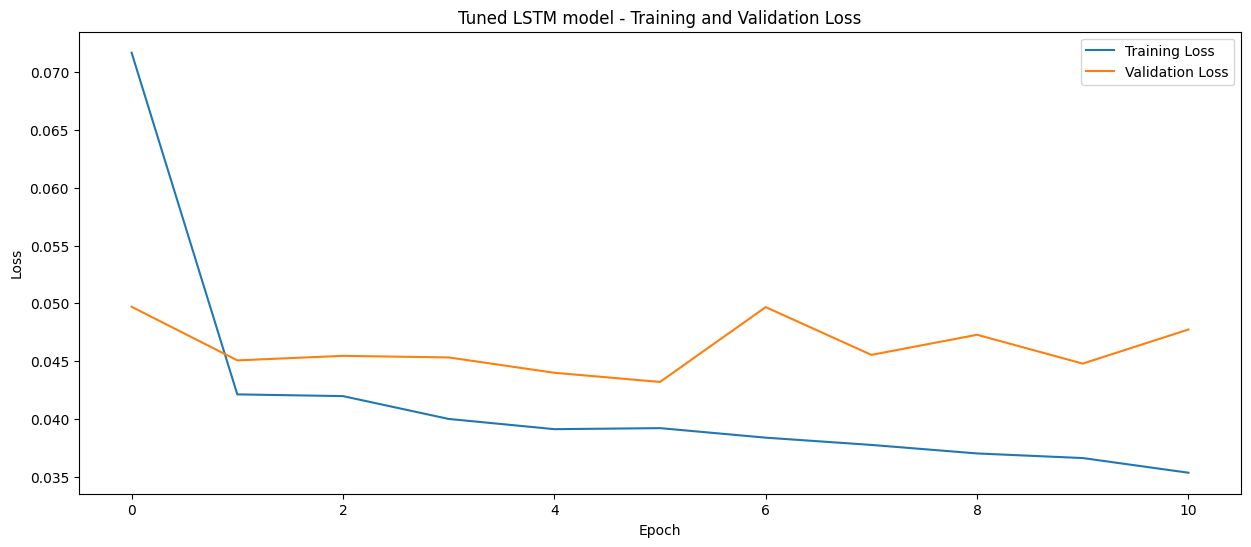

In [66]:
# Plot training and validation loss
plt.figure(figsize=(15,6))
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
plt.title('Tuned LSTM model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
predictions_tuned = tuned_model.predict(X_val)

12/12 [==============================] - 0s 8ms/step


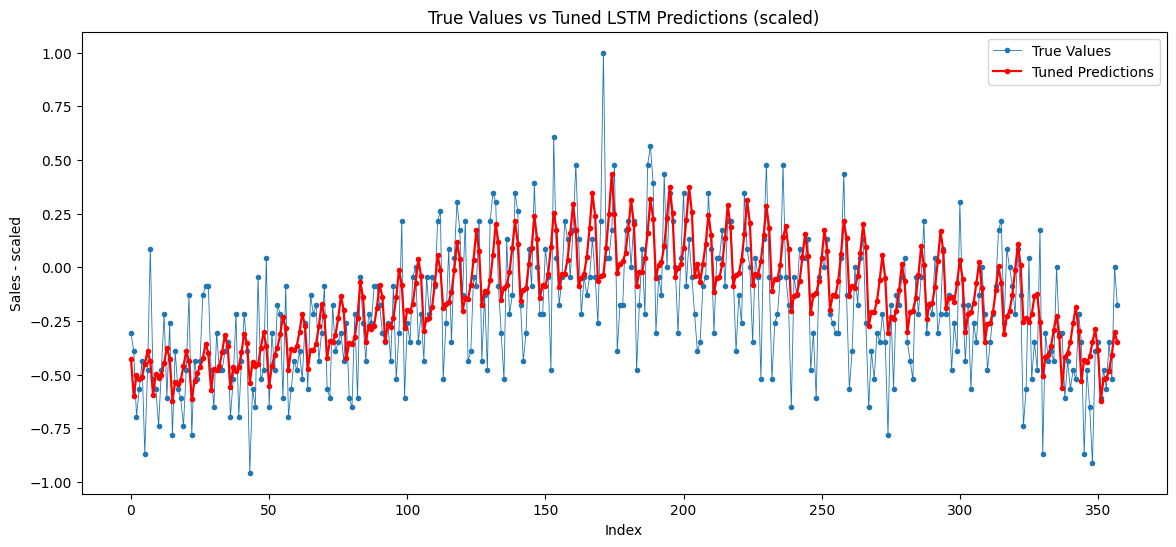

In [68]:
#Plotting the true values from the test set and predicted values (both scaled)
plt.figure(figsize=(14, 6))
plt.plot(y_val, label='True Values', marker='.', linewidth=0.6)
plt.plot(predictions_tuned, label='Tuned Predictions', marker='.', linewidth=1.6, color ='r')
plt.title('True Values vs Tuned LSTM Predictions (scaled)')
plt.xlabel('Index')
plt.ylabel('Sales - scaled')
plt.legend()
plt.show()

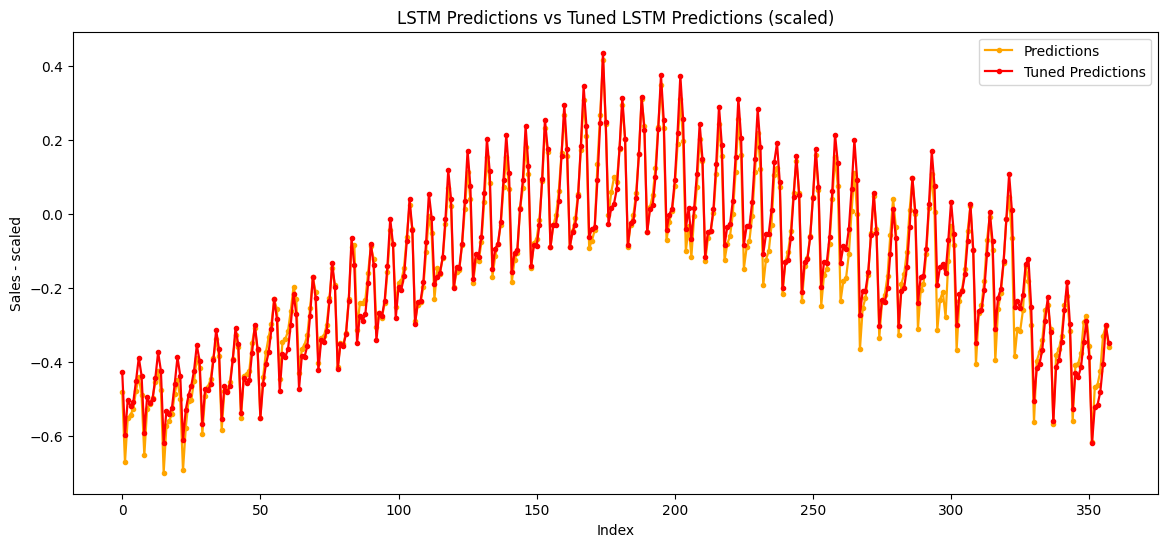

In [69]:
plt.figure(figsize=(14, 6))
plt.plot(predictions, label='Predictions', marker='.', linewidth=1.6, color ='orange')
plt.plot(predictions_tuned, label='Tuned Predictions', marker='.', linewidth=1.6, color ='r')
plt.title('LSTM Predictions vs Tuned LSTM Predictions (scaled)')
plt.xlabel('Index')
plt.ylabel('Sales - scaled')
plt.legend()
plt.show()

In [70]:
# Evaluate the model
mse = np.mean((predictions_tuned - y_val) ** 2)
rmse = np.sqrt(np.mean(predictions_tuned - y_val)**2) 
mae = mean_absolute_error(y_val, predictions_tuned)
mape = mean_absolute_percentage_error(y_val, predictions_tuned)
smape = symmetric_mean_absolute_percentage_error(y_val, predictions_tuned)

print("Tuned LSTM model - Mean Squared Error (MSE):", mse)
print("Tuned LSTM model - Mean Absolute Error (MAE):", mae)
print("Tuned LSTM model - Root Mean Squared Error (RMSE):", rmse)
print("Tuned LSTM model - Mean Absolute Percentage Error (MAPE):", mape)
print("Tuned LSTM model - Symmetric Mean Absolute Percentage Error (SMAPE):", smape)

Tuned LSTM model - Mean Squared Error (MSE): 0.04905084049981614
Tuned LSTM model - Mean Absolute Error (MAE): 0.18034401487278348
Tuned LSTM model - Root Mean Squared Error (RMSE): 0.058464760207287095
Tuned LSTM model - Mean Absolute Percentage Error (MAPE): inf
Tuned LSTM model - Symmetric Mean Absolute Percentage Error (SMAPE): 93.07409863433786


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/1955489358.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [71]:
# Inverse transform the scaled predictions (so we can have the predictions from the test set in the original data scale)
unscaled_predictions_tuned = sales_scaler.inverse_transform(predictions_tuned)

<function matplotlib.pyplot.show(close=None, block=None)>

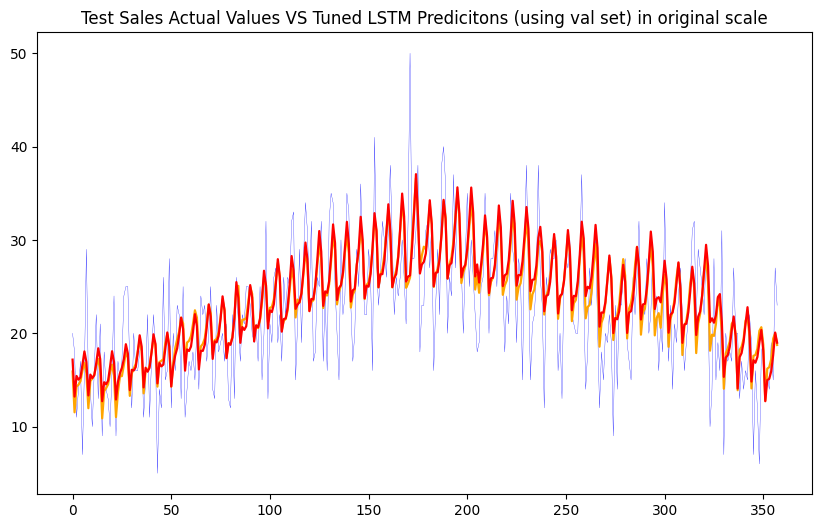

In [72]:
#Plotting unscaled predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(unscaled_y_val, linewidth=0.2, color = 'blue')
plt.plot(unscaled_predictions, label='Predictions',linewidth=1.6, color = 'orange')
plt.plot(unscaled_predictions_tuned, label='Tuned Predictions', linewidth=1.6, color = 'red')
plt.title('Test Sales Actual Values VS Tuned LSTM Predicitons (using val set) in original scale')
plt.show

# 8) Trying another LSTM model with extra LSTM and GRU layers (model 2)

In [73]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model2 = Sequential()

model2.add(LSTM(units=120, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) #sequence_length =30 -> equal to X_train.shape[1]

#First extra LSTM layer
model2.add(LSTM(units=100, return_sequences=True)) 
model2.add(Dropout(0.2))

#Second extra LSTM layer 
model2.add(LSTM(units=50, return_sequences=True))
model2.add(Dropout(0.2))

# First extra GRU layer
model2.add(GRU(units=50, return_sequences=True))
model2.add(Dropout(0.2))

# Second extra GRU layer
model2.add(GRU(units=50, return_sequences=False))
model2.add(Dropout(0.2))

model2.add(Dense(units=1)) # Output layer with 1 unit for predicting 'sales'
model2.compile(optimizer='adam', loss='mean_squared_error')

# Defining EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Training the LSTM model 2 with EarlyStopping
history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x30x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x30x1x50xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerforma

35/36 [============================>.] - ETA: 0s - loss: 0.0698

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<25x30x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<25x30x1x50xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerforma

36/36 [==============================] - 16s 227ms/step - loss: 0.0687 - val_loss: 0.0649
Epoch 2/100
36/36 [==============================] - 3s 70ms/step - loss: 0.0532 - val_loss: 0.0575
Epoch 3/100
36/36 [==============================] - 2s 67ms/step - loss: 0.0555 - val_loss: 0.0587
Epoch 4/100
36/36 [==============================] - 2s 64ms/step - loss: 0.0518 - val_loss: 0.0570
Epoch 5/100
36/36 [==============================] - 2s 66ms/step - loss: 0.0510 - val_loss: 0.0562
Epoch 6/100
36/36 [==============================] - 2s 62ms/step - loss: 0.0506 - val_loss: 0.0566
Epoch 7/100
36/36 [==============================] - 2s 63ms/step - loss: 0.0495 - val_loss: 0.0570
Epoch 8/100
36/36 [==============================] - 2s 65ms/step - loss: 0.0483 - val_loss: 0.0622
Epoch 9/100
36/36 [==============================] - 2s 66ms/step - loss: 0.0464 - val_loss: 0.0550
Epoch 10/100
36/36 [==============================] - 2s 65ms/step - loss: 0.0435 - val_loss: 0.0489
Epoch 11/

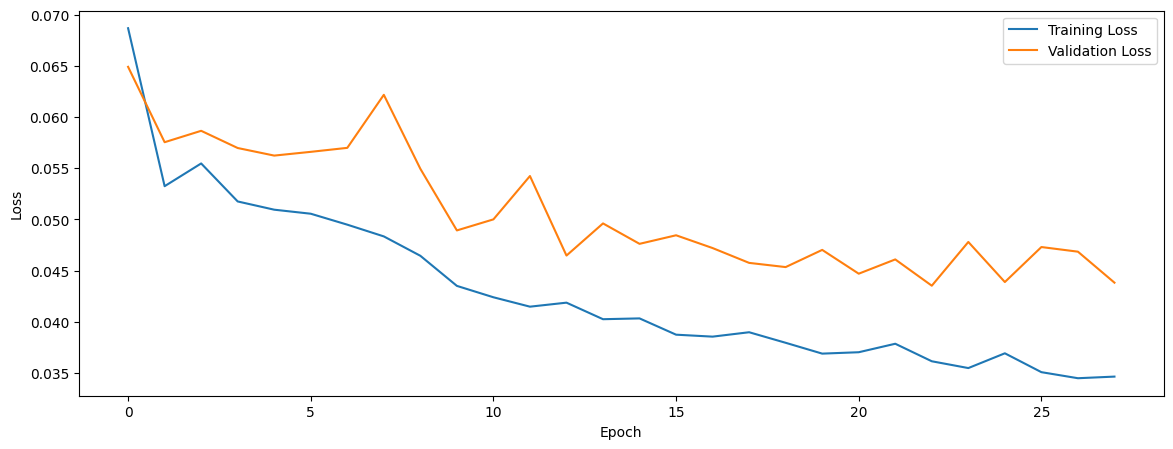

In [74]:
# Plotting the loss
plt.figure(figsize=(14,5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [75]:
# Creating predictions on the test set
predictions2 = model2.predict(X_val)

12/12 [==============================] - 2s 50ms/step


In [76]:
# Evaluating the model
mse = np.mean((predictions2 - y_val) ** 2)
rmse = np.sqrt(np.mean(predictions2 - y_val)**2) 
mae = mean_absolute_error(y_val, predictions2)
mape = mean_absolute_percentage_error(y_val, predictions2)
smape = symmetric_mean_absolute_percentage_error(y_val, predictions2)

print("LSTM model 2 - Mean Squared Error (MSE) - LSTM model 2:", mse)
print("LSTM model 2 - Mean Absolute Error (MAE) - LSTM model 2:", mae)
print("LSTM model 2 - Root Mean Squared Error (RMSE) - LSTM model 2:", rmse)
print("LSTM model 2 - Mean Absolute Percentage Error (MAPE) - LSTM model 2:", mape)
print("LSTM model 2 - Symmetric Mean Absolute Percentage Error (SMAPE):", smape)

LSTM model 2 - Mean Squared Error (MSE) - LSTM model 2: 0.04595807266761316
LSTM model 2 - Mean Absolute Error (MAE) - LSTM model 2: 0.1720774944193927
LSTM model 2 - Root Mean Squared Error (RMSE) - LSTM model 2: 0.01972630332349158
LSTM model 2 - Mean Absolute Percentage Error (MAPE) - LSTM model 2: inf
LSTM model 2 - Symmetric Mean Absolute Percentage Error (SMAPE): 90.38435230759995


/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/1955489358.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


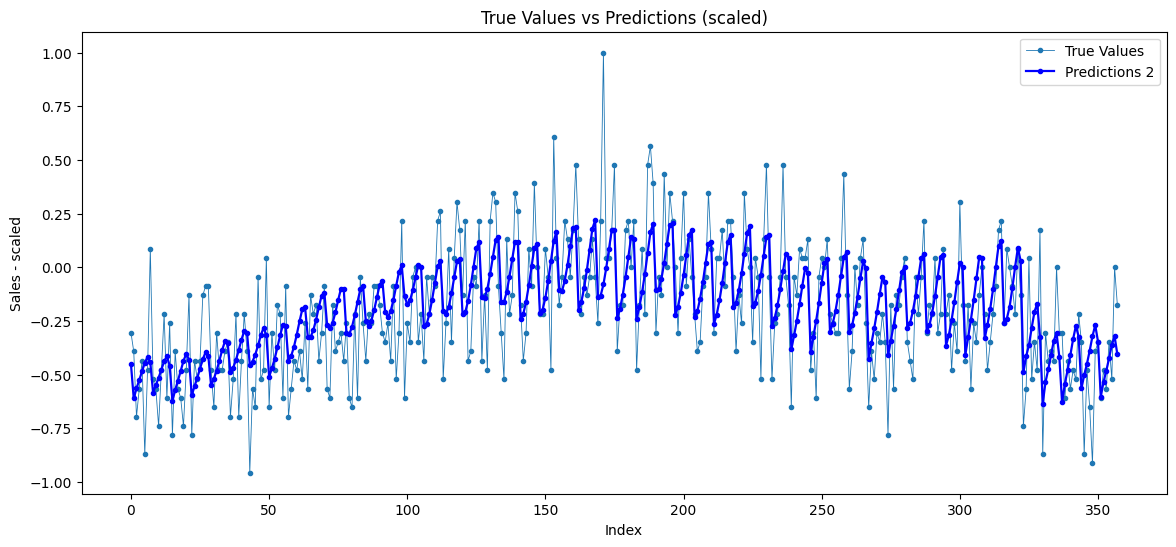

In [77]:
#Plotting the true values from the validation set and predicted values (both scaled)
plt.figure(figsize=(14, 6))
plt.plot(y_val, label='True Values', marker='.', linewidth=0.6)
#plt.plot(predictions, label='Predictions', marker='.', linewidth=1.6, color= 'orange')
plt.plot(predictions2, label='Predictions 2', marker='.', linewidth=1.6, color= 'b')
plt.title('True Values vs Predictions (scaled)')
plt.xlabel('Index')
plt.ylabel('Sales - scaled')
plt.legend()
plt.show()

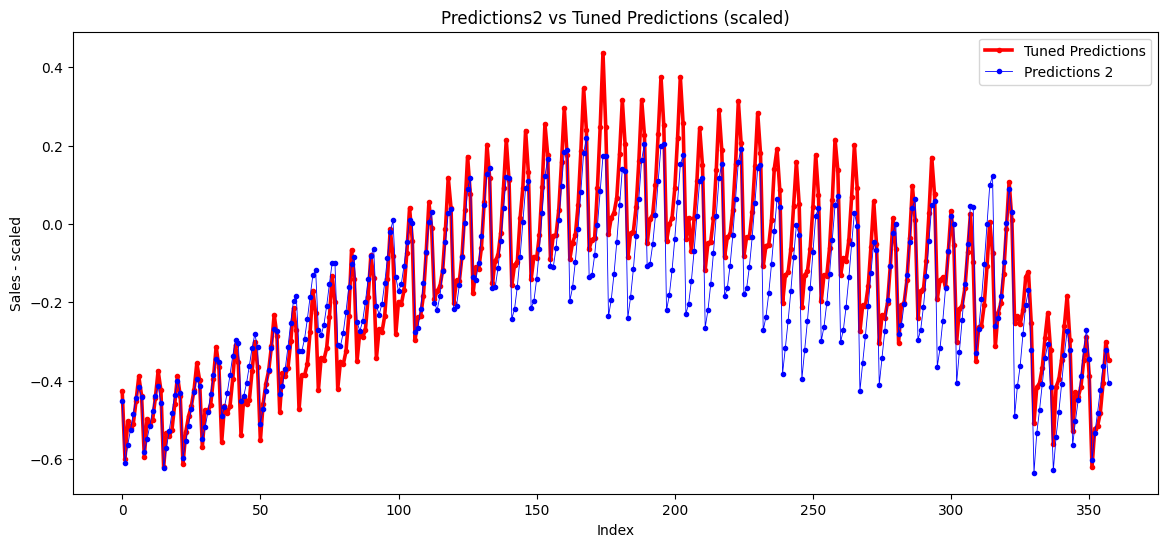

In [78]:
plt.figure(figsize=(14, 6))
#plt.plot(y_val, label='True Values', marker='.', linewidth=0.6)
plt.plot(predictions_tuned, label='Tuned Predictions', marker='.', linewidth=2.6, color= 'r')
plt.plot(predictions2, label='Predictions 2', marker='.', linewidth=0.6, color= 'b')
plt.title('Predictions2 vs Tuned Predictions (scaled)')
plt.xlabel('Index')
plt.ylabel('Sales - scaled')
plt.legend()
plt.show()

In [79]:
# Inverse transform the scaled predictions (so we can have the predictions from the test set in the original data scale)
unscaled_predictions2 = sales_scaler.inverse_transform(predictions2)

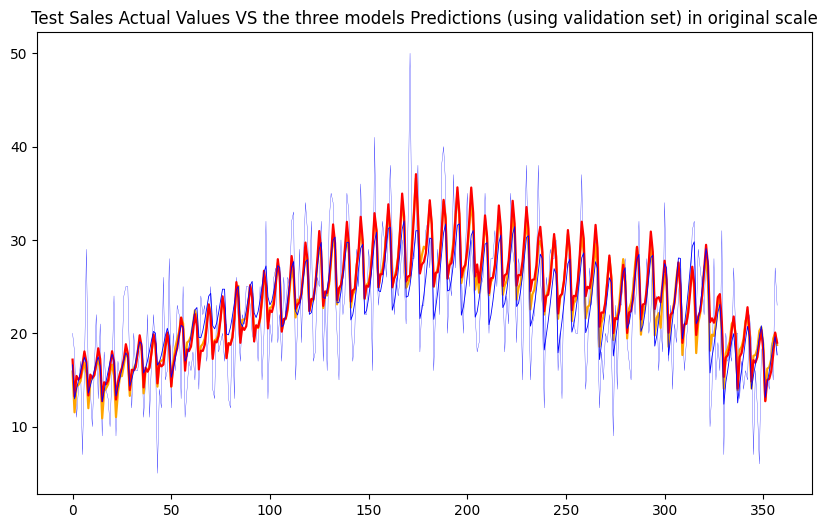

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(unscaled_y_val, linewidth=0.2, color = 'blue')
plt.plot(unscaled_predictions, label='Predictions', linewidth=1.6, color = 'orange')
plt.plot(unscaled_predictions_tuned, label='Tuned Predicitons', linewidth=1.6, color = 'red')
plt.plot(unscaled_predictions2, label='Predictions 2',  linewidth=0.6, color= 'b')
plt.title('Test Sales Actual Values VS the three models Predictions (using validation set) in original scale')
plt.show()

Overall, the three models perform very similarly, with similar metrics and little to choose between them.
All of them are doing pretty good in identifying the recurring trend. 
The possible limit of all three models is that they aren't super precise into capturing the magnitude of the ups and downs of the original time series, but this are still a decent baseline.

Still, I am using the **tuned model** for my predicitons.
Even though model2 seems to have slightly better metrics, and also lower variability and average error mean (see below), actually the tuned model seem to be following data slightly more coherently, trying to better mimic the ups and downs within the original dataset.

In [92]:
#Dataframe to sum up actual validation set values, predictions and errors
df_results = pd.DataFrame({
    'actual': unscaled_y_val.flatten(),
    'LSTM predictions': unscaled_predictions.flatten(),
    'error 1': unscaled_y_val.flatten() - unscaled_predictions.flatten(),
    'Tuned LSTM predictions': unscaled_predictions_tuned.flatten(),
    'error tuned': unscaled_y_val.flatten() - unscaled_predictions_tuned.flatten(),
    'LSTM predictions 2': unscaled_predictions2.flatten(),
    'error 2': unscaled_y_val.flatten() - unscaled_predictions2.flatten()
})

df_results

,actual,LSTM predictions,error 1,Tuned LSTM predictions,error tuned,LSTM predictions 2,error 2
0,20.0,15.904219,4.095781,17.176794,2.823206,16.612753,3.387247
1,18.0,11.529731,6.470269,13.216990,4.783010,12.969995,5.030005
2,11.0,14.287143,-3.287143,15.428010,-4.428010,14.031788,-3.031788
3,14.0,14.483340,-0.483340,15.031556,-1.031556,14.929132,-0.929132
4,17.0,14.871211,2.128789,15.276580,1.723420,15.866026,1.133974
...,...,...,...,...,...,...,...
353,14.0,16.366568,-2.366568,15.118123,-1.118123,15.904146,-1.904146
354,19.0,17.214611,1.785389,15.919621,3.080379,17.266495,1.733505
355,15.0,19.423536,-4.423536,17.664173,-2.664173,18.691727,-3.691727
356,27.0,20.010689,6.989311,20.078455,6.921545,19.627388,7.372612


In [93]:
print('LSTM model mean prediction error:', df_results['error 1'].mean())
print('LSTM model deviation standard prediction error:', df_results['error 1'].std())
print('Tuned LSTM model mean prediction error:', df_results['error tuned'].mean())
print('Tuned LSTM model deviation standard prediction error:', df_results['error tuned'].std())
print('LSTM model 2 mean prediction error:', df_results['error 2'].mean())
print('LSTM model 2 deviation standard prediction error:', df_results['error 2'].std())

LSTM model mean prediction error: -1.047807086113445
LSTM model deviation standard prediction error: 4.922820044289915
Tuned LSTM model mean prediction error: -1.3446894677657655
Tuned LSTM model deviation standard prediction error: 4.9200938089686455
LSTM model 2 mean prediction error: -0.4537050311125855
LSTM model 2 deviation standard prediction error: 4.91665501974597


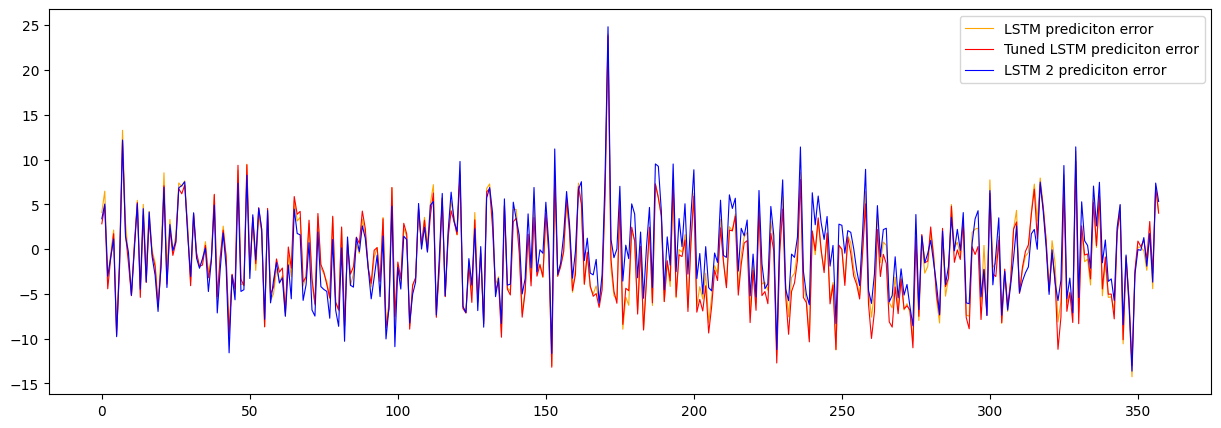

In [102]:
plt.figure(figsize=(15,5))
#plt.plot(df_results['actual'], label='Actual sales') 
#plt.plot(df_results['LSTM predictions'], label='LSTM predictions')
plt.plot(df_results['error 1'], label='LSTM prediciton error', color='orange', linewidth=0.8)
plt.plot(df_results['error tuned'], label='Tuned LSTM prediciton error', color='red', linewidth=0.8)
plt.plot(df_results['error 2'], label='LSTM 2 prediciton error', color='b', linewidth=0.8)
plt.legend()
plt.show()

# 9) Predicting future sales using the tuned model

In [81]:
df_test11.columns

Index(['date', 'store', 'item', 'sales', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max',
       'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max'],
      dtype='object')

In [103]:
features_test = ['store', 'item', 'day', 'week', 'month', 'year',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'is_month_start', 'is_month_end', 'sin_day_of_week', 'cos_day_of_week',
       'sin_month', 'cos_month', 'sin_day_of_year', 'cos_day_of_year',
       'sin_week_of_year', 'cos_week_of_year', 'sales_expanding_mean',
       'sales_expanding_std', 'sales_expanding_min', 'sales_expanding_max',
       'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']


In [104]:
len(cols), len(features_test)

(28, 28)

In [105]:
#Scaling feature data -  This will be the input to feed the model for getting future item1 in store1 predictions

feat_test_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_test_features = feat_test_scaler.fit_transform(df_test11[features_test])
scaled_test_features.shape

(90, 28)

In [117]:
#Reshaping
scaled_test_features_reshaped = np.expand_dims(scaled_test_features, axis=1)

# Now it should have shape (num_samples, 1, num_features), we can make final predictions
future_predictions = tuned_model.predict(scaled_test_features_reshaped)

3/3 [==============================] - 0s 6ms/step


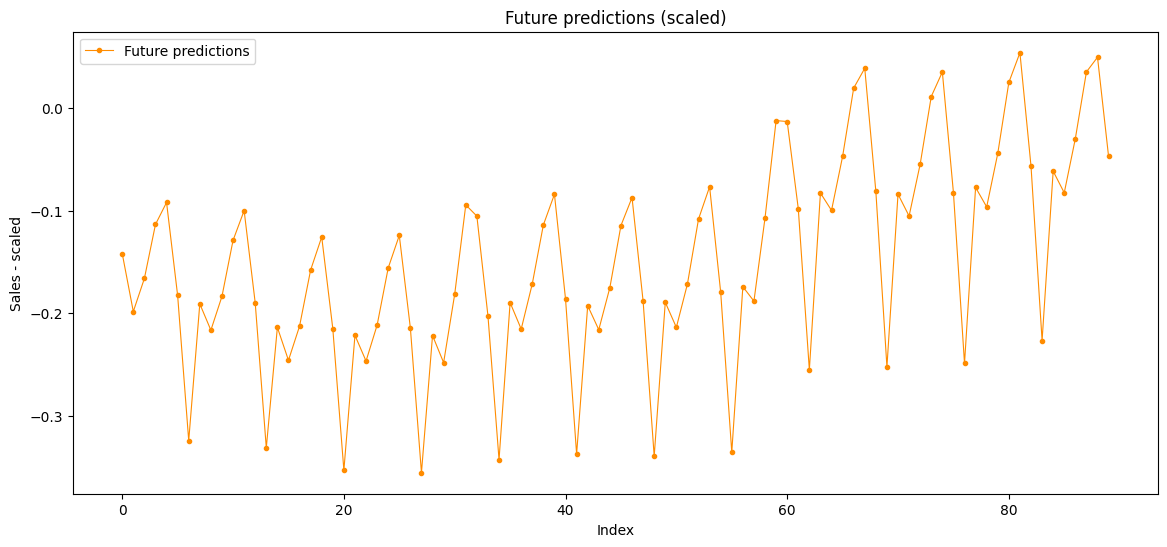

In [118]:
plt.figure(figsize=(14, 6))
plt.plot(future_predictions, label='Future predictions', marker='.', linewidth=0.8, color = 'darkorange')
plt.title('Future predictions (scaled)')
plt.xlabel('Index')
plt.ylabel('Sales - scaled')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

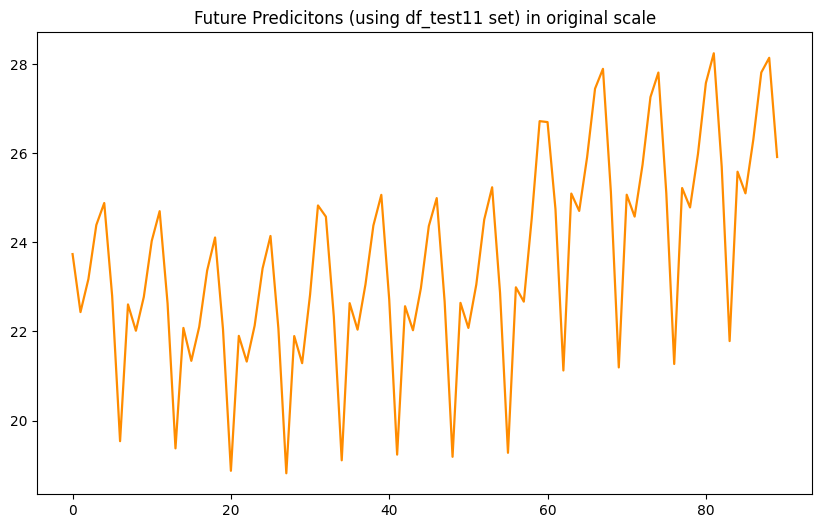

In [119]:
#Final predictions in the correct scale
unscaled_future_predictions = sales_scaler.inverse_transform(future_predictions)
unscaled_future_predictions.shape 

plt.figure(figsize=(10, 6))
plt.plot(unscaled_future_predictions, linewidth=1.6, color = 'darkorange')
plt.title('Future Predicitons (using df_test11 set) in original scale')
plt.show

In [120]:
#Applying predictions to df_test11

df_test11['sales'] = unscaled_future_predictions
df_test11

/var/folders/t3/9f4_1rvd0zq18r6tpxq933zw0000gn/T/ipykernel_12334/3474410500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test11['sales'] = unscaled_future_predictions


,date,store,item,sales,day,week,month,year,day_of_week,day_of_year,...,sin_week_of_year,cos_week_of_year,sales_expanding_mean,sales_expanding_std,sales_expanding_min,sales_expanding_max,rolling_mean,rolling_std,rolling_min,rolling_max
912994,2018-01-01,1,1,23.736769,1,1,1,2018,0,1,...,0.120537,0.992709,52.250287,28.801144,0.0,231.0,54.337143,12.727437,38.81,73.86
912995,2018-01-02,1,1,22.435019,2,1,1,2018,1,2,...,0.120537,0.992709,52.250287,28.801144,0.0,231.0,54.392857,12.836313,38.63,74.00
912996,2018-01-03,1,1,23.177000,3,1,1,2018,2,3,...,0.120537,0.992709,52.250287,28.801144,0.0,231.0,54.428571,12.906437,38.66,74.22
912997,2018-01-04,1,1,24.389633,4,1,1,2018,3,4,...,0.120537,0.992709,52.250287,28.801144,0.0,231.0,54.345714,12.832878,38.66,74.22
912998,2018-01-05,1,1,24.883606,5,1,1,2018,4,5,...,0.120537,0.992709,52.250287,28.801144,0.0,231.0,53.667143,12.375361,38.70,74.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913079,2018-03-27,1,1,25.100517,27,13,3,2018,1,86,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,70.268571,15.478997,49.38,93.43
913080,2018-03-28,1,1,26.315853,28,13,3,2018,2,87,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,70.177143,15.595947,48.96,93.47
913081,2018-03-29,1,1,27.813246,29,13,3,2018,3,88,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,70.194286,15.281464,48.89,93.06
913082,2018-03-30,1,1,28.143316,30,13,3,2018,4,89,...,1.0,-0.0,52.250287,28.801144,0.0,231.0,69.764286,14.359572,48.83,90.82


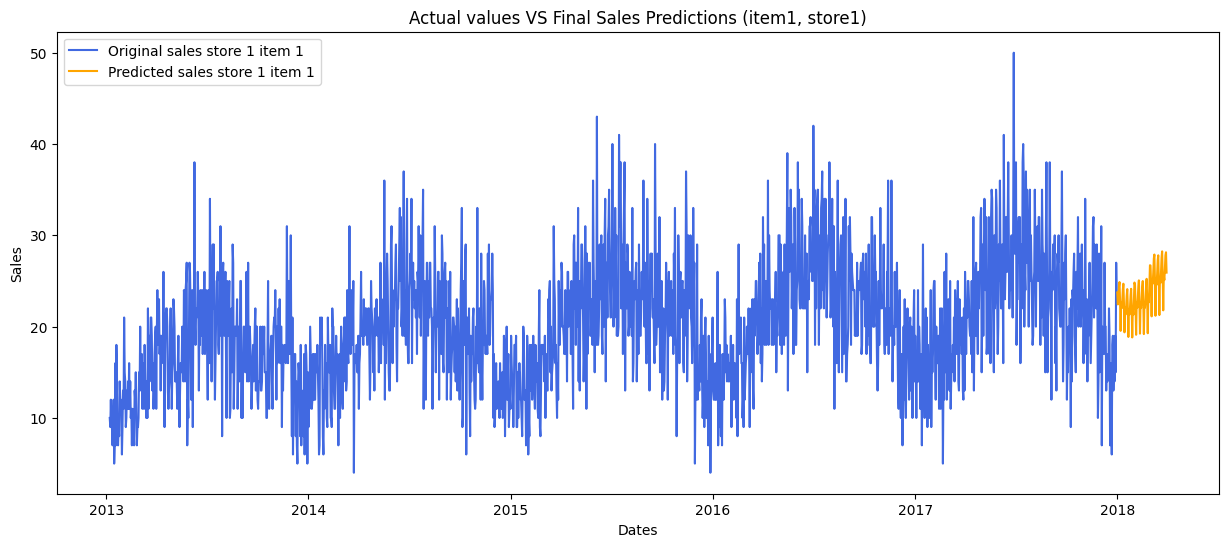

In [121]:
#Plotting
plt.figure(figsize=(15,6))
plt.plot(df_train11['date'], df_train11['sales'], label='Original sales store 1 item 1', color='royalblue', linewidth=1.5)
plt.plot(df_test11['date'], df_test11['sales'], label='Predicted sales store 1 item 1', color='orange', linewidth=1.5)
plt.title('Actual values VS Final Sales Predictions (item1, store1)')
plt.xlabel('Dates')
plt.ylabel('Sales')
plt.legend()
plt.show()